# Setup enviornment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/'Colab Notebooks'/Thesis/PeerRead/code/accept_classify/

/content/drive/MyDrive/Colab Notebooks/Thesis/PeerRead/code/accept_classify


Import library and Load Data

In [ ]:
import json, pickle, os
import pandas as pd
import nltk
from tqdm.notebook import tqdm

In [ ]:
with open('../../my_data/01-Paper-Acceptance/paper_review', "rb") as f:
  all_data=pickle.load(f)

train_data, train_target, val_data, val_target, test_data, test_target = all_data

# Classification of text documents

In [ ]:
import logging
import sys
from time import time
import matplotlib.pyplot as plt
import numpy as np

#from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics 
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
#Train the models and test on validation set
target_names = train_target


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(train_data)
data_val_size_mb = size_mb(val_data)

print("%d documents - %0.3fMB (training set)" % (
    len(train_data), data_train_size_mb))
print("%d documents - %0.3fMB (val set)" % (
    len(val_data), data_val_size_mb))
print("%d categories" % len(target_names))
print()


y_train, y_val = train_target, val_target


print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=20000,
                                 stop_words='english')
X_train = vectorizer.fit_transform(train_data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the validation data using the same vectorizer")
t0 = time()
X_val = vectorizer.transform(val_data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_val_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_val.shape)
print()

# mapping from integer feature name to original token string
feature_names = None

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


349 documents - 10.892MB (training set)
39 documents - 1.357MB (val set)
349 categories

Extracting features from the training data using a sparse vectorizer
done in 1.257668s at 8.661MB/s
n_samples: 349, n_features: 20000

Extracting features from the validation data using the same vectorizer
done in 0.141016s at 9.623MB/s
n_samples: 39, n_features: 20000



In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_val)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_val, pred)
    print("accuracy:   %0.3f" % score)
    
    fpr, tpr, threshold = roc_curve(y_val, pred)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: %0.3f" % roc_auc)


    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        #(RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        #(PassiveAggressiveClassifier(max_iter=50),"Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=2), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    #results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    #results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
#print('=' * 80)
#print("Elastic-Net penalty")
#results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty="elasticnet")))

# Train NearestCentroid without threshold
#print('=' * 80)
#print("NearestCentroid (aka Rocchio classifier)")
#results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

#print('=' * 80)
#print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
#results.append(benchmark(Pipeline([
 # ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  #tol=1e-3))),
  #('classification', LinearSVC(penalty="l2"))])))

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.009s
test time:  0.001s
accuracy:   0.615
roc_auc: 0.607
dimensionality: 20000
density: 0.877050

kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
train time: 0.004s
test time:  0.021s
accuracy:   0.615
roc_auc: 0.627

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, 

<function matplotlib.pyplot.show>

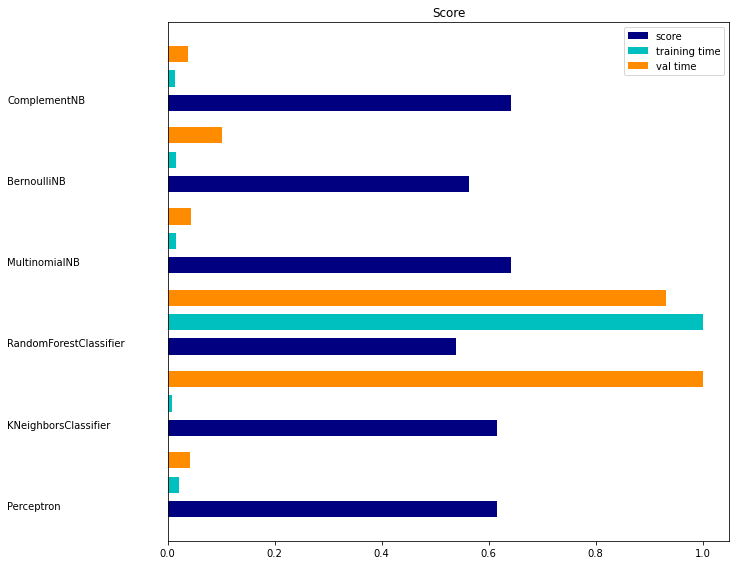

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, val_time = results
training_time = np.array(training_time) / np.max(training_time)
val_time = np.array(val_time) / np.max(val_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, val_time, .2, label="val time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show

In [ ]:
full_train_data = train_data + val_data
full_train_target = train_target + val_target

In [ ]:
#Train the models and test on test set
target_names = full_train_target


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(full_train_data)
data_test_size_mb = size_mb(test_data)

print("%d documents - %0.3fMB (training set)" % (
    len(full_train_data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(test_data), data_test_size_mb))
print("%d categories" % len(target_names))
print()


y_train, y_test = full_train_target, test_target


print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=20000,
                                 stop_words='english')
X_fulltrain = vectorizer.fit_transform(full_train_data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_fulltrain.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(test_data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
feature_names = None

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


388 documents - 12.249MB (training set)
38 documents - 1.191MB (test set)
388 categories

Extracting features from the training data using a sparse vectorizer
done in 1.235594s at 9.914MB/s
n_samples: 388, n_features: 20000

Extracting features from the test data using the same vectorizer
done in 0.122094s at 9.752MB/s
n_samples: 38, n_features: 20000



In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_fulltrain, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.4f" % score)

    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: %0.4f" % roc_auc)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.048s
test time:  0.001s
accuracy:   0.6053
roc_auc: 0.5464
dimensionality: 20000
density: 1.000000

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.008s
test time:  0.001s
accuracy:   0.6316
roc_auc: 0.5913
dimensionality: 20000
density: 0.890000

Passive-Aggressive
_______________________________________________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 0.410s
test time:  0.016s
accuracy:   0.6316
roc_auc: 0.5565

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.031s
test time:  0.001s
accuracy:   0.6316
roc_auc: 0.5797
dimensionality: 20000
density: 1.000000

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction

<function matplotlib.pyplot.show>

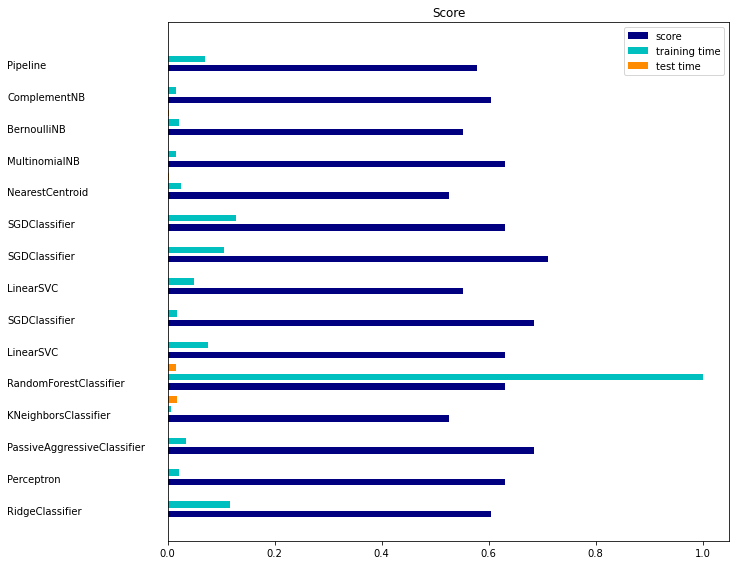

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
val_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show

In [ ]:
from sklearn import tree
X, y = X_fulltrain, y_train
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X, y)


[Text(202.275, 195.696, 'X[17048] <= 0.008\ngini = 0.482\nsamples = 388\nvalue = [231, 157]'),
 Text(111.60000000000001, 152.208, 'X[7770] <= 0.011\ngini = 0.415\nsamples = 235\nvalue = [166, 69]'),
 Text(55.800000000000004, 108.72, 'X[615] <= 0.015\ngini = 0.324\nsamples = 167\nvalue = [133, 34]'),
 Text(27.900000000000002, 65.232, 'X[300] <= 0.024\ngini = 0.272\nsamples = 154\nvalue = [129, 25]'),
 Text(13.950000000000001, 21.744, 'gini = 0.211\nsamples = 142\nvalue = [125, 17]'),
 Text(41.85, 21.744, 'gini = 0.444\nsamples = 12\nvalue = [4, 8]'),
 Text(83.7, 65.232, 'X[17020] <= 0.006\ngini = 0.426\nsamples = 13\nvalue = [4, 9]'),
 Text(69.75, 21.744, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(97.65, 21.744, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(167.4, 108.72, 'X[16876] <= 0.015\ngini = 0.5\nsamples = 68\nvalue = [33, 35]'),
 Text(139.5, 65.232, 'X[12940] <= 0.006\ngini = 0.444\nsamples = 48\nvalue = [16, 32]'),
 Text(125.55000000000001, 21.744, 'gini = 0.343\nsam

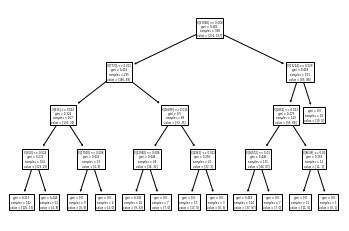

In [ ]:
 tree.plot_tree(clf)

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Paper")

'Paper.pdf'

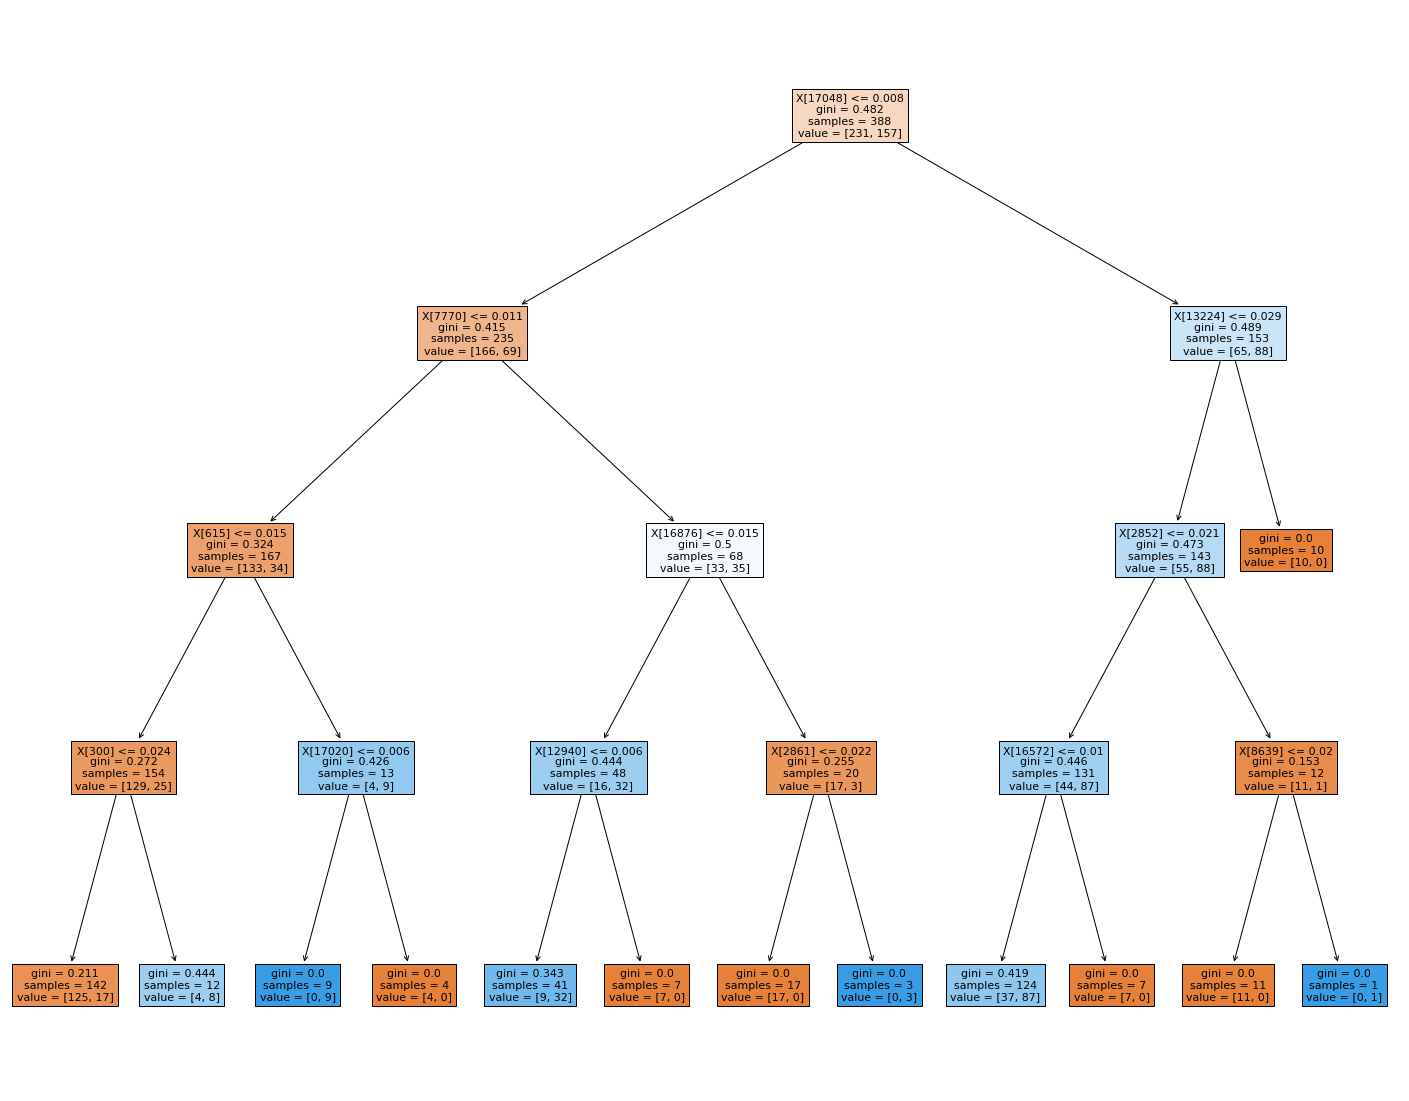

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   filled=True)


# Neural Network (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
for r in range(3):  
  clf = MLPClassifier(random_state=r, max_iter=100).fit(X_train, train_target)
  print(r,clf.score(X_test, test_target))


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0 0.5789473684210527


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1 0.6052631578947368
2 0.6052631578947368


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2 0.6410256410256411


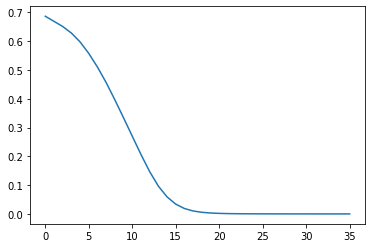

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=100, hidden_layer_sizes=(100,100,100),learning_rate_init=0.001).fit(X_train, train_target)
print(r,clf.score(X_val, val_target))
plt.plot(clf.loss_curve_)

In [ ]:
pred = clf.predict(X_val)

score = metrics.accuracy_score(y_val, pred)
print("accuracy:   %0.3f" % score)

fpr, tpr, threshold = roc_curve(y_val, pred)
roc_auc = auc(fpr, tpr)
print("roc_auc: %0.3f" % roc_auc)

accuracy:   0.641
roc_auc: 0.631


2 0.6842105263157895


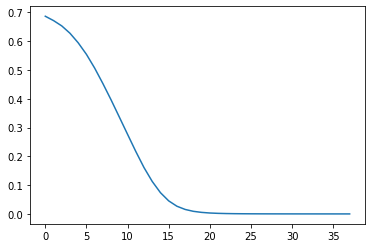

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,100,100),learning_rate_init=0.001).fit(X_fulltrain, full_train_target)
print(r,clf.score(X_test, test_target))
plt.plot(clf.loss_curve_)

In [ ]:
pred = clf.predict(X_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.4f" % score)

fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print("roc_auc: %0.4f" % roc_auc)

accuracy:   0.6842
roc_auc: 0.6464


# PyTorch MLP

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fc1 = nn.Linear(31715, 300)
        self.fc1 = nn.Linear(20000, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

In [ ]:
xt_train=torch.Tensor(X_train.toarray())
yt_train = torch.Tensor(train_target).type(torch.LongTensor)
xt_test = torch.Tensor(X_test.toarray())
yt_test = torch.Tensor(test_target).type(torch.LongTensor)

In [ ]:
from tqdm.notebook import trange,tqdm

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
Loss = []
Acc  = []
# Train the network
for epoch in trange(100):  # loop over the dataset multiple times
  # zero the parameter gradients
  optimizer.zero_grad()
  # forward + backward + optimize
  outputs = net(xt_train)
  loss = criterion(outputs, yt_train)
  Loss.append(loss)
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    outputs = net(xt_test)
    Acc.append((outputs.argmax(axis=1)==yt_test).sum()/len(yt_test))  

plt.plot(Loss)
plt.plot(Acc)    

In [ ]:
plt.hist(outputs.detach().numpy().max(axis=1),bins=20)